In [5]:
!pip install apiclient
!pip install isodate



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
import json
from csv import writer
from googleapiclient.discovery import build
import pandas as pd
import numpy as np
import pickle
import urllib.request
import urllib

import isodate

In [16]:
# youtube api call

key = ''

def build_service():
    YOUTUBE_API_SERVICE_NAME = "youtube"
    YOUTUBE_API_VERSION = "v3"
    return build(YOUTUBE_API_SERVICE_NAME,YOUTUBE_API_VERSION,
                 developerKey=key)


def get_videos( keyword,
               
               part='snippet,contentDetails,statistics',
               maxResults = 50,
               textFormat = 'plainText',
               type='video',
               csv_filename = "utube_data",
               ):
    
    #initiate lists to store info
    titles, view_counts, like_counts, comment_counts, fav_counts, times, duration, descriptions, tags, channels, language = [],[], [],[],[],[],[],[],[],[],[]

    #build the service that will connect to youtube api
    service = build_service()
    iteration = 0

    # while iteration < 4:
    #make API call using the service
    response = service.search().list(
        q=keyword, 
        # pageToken = pageToken,
        part='id',
        type=type,
        maxResults = maxResults,
    ).execute()
    
    
    while response:
        
        video_ids = [item['id']['videoId'] for item in response['items']] 
        
        #can retrieve all stats if vid_id is available
        video_response = service.videos().list(
            part=part,
            id=','.join(video_ids)
        ).execute()

        for video in video_response['items']:
            title = video['snippet']['title']
            view_count = video['statistics'].get('viewCount')
            like_count = video['statistics'].get('likeCount')
            fav_count = video['statistics'].get('favoriteCount')
            com_count = video['statistics'].get('commentCount') 
            time = video['snippet']['publishedAt']
            lang = video['snippet'].get('defaultAudioLanguage')
            desc = video['snippet']['description']
            tag = video['snippet'].get('tags') 
            channel = video['snippet']['channelTitle']
            dur = isodate.parse_duration(video['contentDetails']['duration']).total_seconds()

            #append to lists
            titles.append(title)
            view_counts.append(view_count)
            like_counts.append(like_count)
            fav_counts.append(fav_count)
            comment_counts.append(com_count)
            times.append(time)
            descriptions.append(desc)
            tags.append(tag)
            channels.append(channel)
            language.append(lang)
            duration.append(dur)
        
        page_token = response.get('nextPageToken')
        
        if len(titles) > 1000 or not page_token:
            break

        elif page_token:
            print(len(titles))
            response = service.search().list(
                q=keyword, 
                pageToken = page_token,
                part='id',
                type=type,
                maxResults = maxResults).execute()


    return {
        'title':titles,
        'view_count':view_counts,
        'like_count':like_counts,
        'favorite_count':fav_counts,
        'comment_count':comment_counts,
        'publish_time':times,
        'duration':duration,
        'language':language,
        'description':descriptions,
        'tags':tags,
        'channel':channels
    }

In [18]:
data = get_videos('Richard Feynman')

50
100
150
200
250
300
350
400
450
500


In [20]:
df = pd.DataFrame(data)
df.head()

,title,view_count,like_count,favorite_count,comment_count,publish_time,duration,language,description,tags,channel
0,The complete FUN TO IMAGINE with Richard Feynman,4165520,87497,0,7292,2018-11-01T13:22:07Z,4010.0,en-US,You can find an HD upload at https://youtu.be/...,"[feynman, science, physics, history, philosoph...",Christopher Sykes
1,"There's no such thing as MIRACLE, Richard Feyn...",3894360,145637,0,2841,2020-08-26T20:21:49Z,320.0,None,"In this video, Richard Feynman talks about why...","[study with me, study, music for studying, foc...",BTY 365
2,Richard Feynman talks about Algebra,1383026,28242,0,1592,2014-01-22T19:33:22Z,82.0,None,From the Pleasure of Finding Things Out. I lov...,"[Richard Feynman (Author), Algebra (Mathematic...",David Petro
3,Inside the Mind of Richard Feynman: The Great ...,1295632,40328,0,2102,2013-03-04T20:01:32Z,624.0,en,"In today's SciShow episode of Great Minds, we'...","[richard feynman, quantum electrodynamics, con...",SciShow
4,The best teacher I never had,4618209,170957,0,2872,2016-01-27T16:01:46Z,156.0,en,A video tribute from Bill Gates to Richard Fey...,None,Bill Gates


In [29]:
# df.to_csv('uncleaned_data.csv')

In [13]:
# test_data = get_videos('Richard Feynman')

50


In [30]:
# pd.DataFrame(test_data).to_csv('data_snippet.csv')

## Cleaning

In [31]:
df.dtypes

title              object
view_count         object
like_count         object
favorite_count     object
comment_count      object
publish_time       object
duration          float64
language           object
description        object
tags               object
channel            object
dtype: object

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           511 non-null    object 
 1   view_count      511 non-null    object 
 2   like_count      504 non-null    object 
 3   favorite_count  511 non-null    object 
 4   comment_count   506 non-null    object 
 5   publish_time    511 non-null    object 
 6   duration        511 non-null    float64
 7   language        215 non-null    object 
 8   description     511 non-null    object 
 9   tags            372 non-null    object 
 10  channel         511 non-null    object 
dtypes: float64(1), object(10)
memory usage: 44.0+ KB


In [33]:
# convert to correct types before describe()
df.describe()

,duration
count,511.000000
mean,831.812133
std,2234.989907
min,6.000000
25%,58.500000
50%,188.000000
75%,622.000000
max,30132.000000


In [40]:
# Inspect the null values to see if that means 0 or missing

# for like_count first, then function
df['like_count'].value_counts()

0        23
1         9
4         8
15        8
3         6
         ..
6898      1
17247     1
1340      1
5397      1
747       1
Name: like_count, Length: 325, dtype: int64

#### processing like_count

In [95]:
# manually check on youtube: really 0 likes => replace np.nan with 0

df[df['like_count'].isna()].head()

,title,view_count,like_count,favorite_count,comment_count,publish_time,duration,language,description,tags,channel
134,O Fantástico Senhor Feynman DUBLADO (The Fanta...,22070,None,0,None,2022-01-04T21:51:06Z,3121.0,pt-BR,"Richard Feynman, um dos cientistas mais influe...","[Física, Astronomia, Ensino, Ciência]",FisicaNET
180,HOW TO LEARN FASTER EFFECTIVELY BY RICHARD F...,20906,None,0,34,2020-05-07T10:01:01Z,154.0,en-IN,#lifeteasers #richardfeynman #faster #knowledg...,[HOW TO LEARN FASTER AND EFFECTIVELY | RICHARD...,Life Teasers
288,Richard Feynman on Quantum Mechanics Part 3 El...,5424,None,0,None,2017-11-14T05:56:19Z,5996.0,en,Third of the Sir Douglas Robb Lectures done by...,"[Richard Feynman, Aucland]",adrianositizano
293,Richard Feynman the great scientist sketch ✏️✏...,1370,None,0,8,2023-05-29T11:37:41Z,16.0,None,,None,Anulok's Imagination
324,O Fantástico Senhor Feynman DUBLADO (The Fanta...,22070,None,0,None,2022-01-04T21:51:06Z,3121.0,pt-BR,"Richard Feynman, um dos cientistas mais influe...","[Física, Astronomia, Ensino, Ciência]",FisicaNET


In [96]:
# df[df['like_count']]
df['like_count'].replace(np.nan,'0',inplace=True)

In [97]:
#check again => 0 None now
df[df['like_count'].isna()].head()

,title,view_count,like_count,favorite_count,comment_count,publish_time,duration,language,description,tags,channel


#### processing comment_count

In [98]:
df[df['comment_count'].isna()]

,title,view_count,like_count,favorite_count,comment_count,publish_time,duration,language,description,tags,channel
22,Today's Answers to Newton's Queries about Ligh...,334278,6362,0,None,2015-06-03T07:11:36Z,22132.0,None,0:00:00 Photons: Corpuscles of Light\n1:17:32 ...,"[physics, richard feynman, feynman, Isaac Newt...",Trev M
134,O Fantástico Senhor Feynman DUBLADO (The Fanta...,22070,0,0,None,2022-01-04T21:51:06Z,3121.0,pt-BR,"Richard Feynman, um dos cientistas mais influe...","[Física, Astronomia, Ensino, Ciência]",FisicaNET
288,Richard Feynman on Quantum Mechanics Part 3 El...,5424,0,0,None,2017-11-14T05:56:19Z,5996.0,en,Third of the Sir Douglas Robb Lectures done by...,"[Richard Feynman, Aucland]",adrianositizano
324,O Fantástico Senhor Feynman DUBLADO (The Fanta...,22070,0,0,None,2022-01-04T21:51:06Z,3121.0,pt-BR,"Richard Feynman, um dos cientistas mais influe...","[Física, Astronomia, Ensino, Ciência]",FisicaNET
381,O Fantástico Senhor Feynman DUBLADO (The Fanta...,22070,0,0,None,2022-01-04T21:51:06Z,3121.0,pt-BR,"Richard Feynman, um dos cientistas mais influe...","[Física, Astronomia, Ensino, Ciência]",FisicaNET


In [99]:
df['comment_count'].replace(np.nan,'0',inplace=True)

In [100]:
# check again => 0 None
df[df['comment_count'].isna()]

,title,view_count,like_count,favorite_count,comment_count,publish_time,duration,language,description,tags,channel


#### convert like_count and comment_count to int


In [101]:
df['like_count'] = df['like_count'].astype(int)
df['comment_count'] = df['comment_count'].astype(int)
# df['duration'] = df['duration'].astype(int)


In [104]:
# drop favorite_count
df.drop('favorite_count',axis=1,inplace=True)

#### processing language: too many missing values, just ignore col for now

In [106]:
sum(df['language'].isna())

296

#### processing tags

In [107]:
sum(df['tags'].isna()) # just change this to an empty list

139

In [110]:
df['tags'].replace(np.nan,'[]',inplace=True)

#### add month, year col to df

In [169]:
# add month, year column to df
df['date'] = pd.to_datetime(df['publish_time']).dt.date
df['time'] = pd.to_datetime(df['publish_time']).dt.time
df['year'] = pd.to_datetime(df['publish_time']).dt.year


#### add title and desc length to df

In [170]:
def count_length(phrase):
    to_list = phrase.split()
    return len(to_list)

df['title_len'] = df['title'].apply(count_length)
df['desc_len'] = df['description'].apply(count_length)
df.head(10)

,title,view_count,like_count,comment_count,publish_time,duration,language,description,tags,channel,date,time,year,tag_num,title_len,desc_len
0,The complete FUN TO IMAGINE with Richard Feynman,4165520,87497,7292,2018-11-01T13:22:07Z,4010.0,en-US,You can find an HD upload at https://youtu.be/...,"[feynman, science, physics, history, philosoph...",Christopher Sykes,2018-11-01,13:22:07,2018,36,8,98
1,"There's no such thing as MIRACLE, Richard Feyn...",3894360,145637,2841,2020-08-26T20:21:49Z,320.0,None,"In this video, Richard Feynman talks about why...","[study with me, study, music for studying, foc...",BTY 365,2020-08-26,20:21:49,2020,18,14,79
2,Richard Feynman talks about Algebra,1383026,28242,1592,2014-01-22T19:33:22Z,82.0,None,From the Pleasure of Finding Things Out. I lov...,"[Richard Feynman (Author), Algebra (Mathematic...",David Petro,2014-01-22,19:33:22,2014,3,5,33
3,Inside the Mind of Richard Feynman: The Great ...,1295632,40328,2102,2013-03-04T20:01:32Z,624.0,en,"In today's SciShow episode of Great Minds, we'...","[richard feynman, quantum electrodynamics, con...",SciShow,2013-03-04,20:01:32,2013,25,9,113
4,The best teacher I never had,4618209,170957,2872,2016-01-27T16:01:46Z,156.0,en,A video tribute from Bill Gates to Richard Fey...,[],Bill Gates,2016-01-27,16:01:46,2016,2,6,21
5,How an “Ordinary” Man Won the Nobel Prize in P...,765480,22904,1401,2023-01-26T15:57:02Z,971.0,en,Richard Feynman's mind worked in fascinating w...,"[richard feynman, feynman, quantum electrodyna...",Newsthink,2023-01-26,15:57:02,2023,13,10,383
6,How To Study Hard - Richard Feynman,1066373,56098,602,2023-02-07T20:03:28Z,199.0,None,“Study hard what interests you the most in the...,[],Arjun Kocher,2023-02-07,20:03:28,2023,2,7,46
7,Richard Feynman. Why.,4385090,120677,12801,2012-04-02T12:18:49Z,453.0,None,Richard Feynman. Why.,"[Richard, Feynman, Why]",firewalker,2012-04-02,12:18:49,2012,3,3,3
8,Leonard Susskind: My friend Richard Feynman,873098,19719,637,2011-05-16T13:45:25Z,882.0,None,http://www.ted.com What's it like to be pals w...,"[Leonard, Susskind, TEDTalks, TED, talks, Rich...",TED,2011-05-16,13:45:25,2011,8,6,165
9,BBC - The Fantastic Mr Feynman,219967,6098,180,2016-01-27T21:30:04Z,3577.0,en,REVIEW\n\nGerard O'Donovan reviews The Fantast...,"[Feynman, BBC, Physics]",Sebastiaan Deerenberg,2016-01-27,21:30:04,2016,3,6,351


In [175]:
df.dtypes

title             object
view_count         int32
like_count         int32
comment_count      int32
publish_time      object
duration         float64
language          object
description       object
tags              object
channel           object
date              object
time              object
year               int64
tag_num            int64
title_len          int64
desc_len           int64
dtype: object

In [70]:
# change type from object to int or float
df['view_count'] = df['view_count'].astype(int,errors='ignore')
df['like_count'] = df['like_count'].astype(int,errors='ignore')
df['comment_count'] = df['comment_count'].astype(int,errors='ignore')


In [115]:
# confirm final cleaned data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          511 non-null    object 
 1   view_count     511 non-null    int32  
 2   like_count     511 non-null    int32  
 3   comment_count  511 non-null    int32  
 4   publish_time   511 non-null    object 
 5   duration       511 non-null    float64
 6   language       215 non-null    object 
 7   description    511 non-null    object 
 8   tags           511 non-null    object 
 9   channel        511 non-null    object 
 10  date           511 non-null    object 
 11  time           511 non-null    object 
 12  year           511 non-null    int64  
dtypes: float64(1), int32(3), int64(1), object(8)
memory usage: 46.0+ KB


### feature engineering: create tag_num col

In [122]:
df['tag_num'] = df['tags'].apply(len)

In [123]:
df.dtypes

title             object
view_count         int32
like_count         int32
comment_count      int32
publish_time      object
duration         float64
language          object
description       object
tags              object
channel           object
date              object
time              object
year               int64
tag_num            int64
dtype: object

## EDA

In [116]:
# import viz lib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

c:\Users\MrLinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


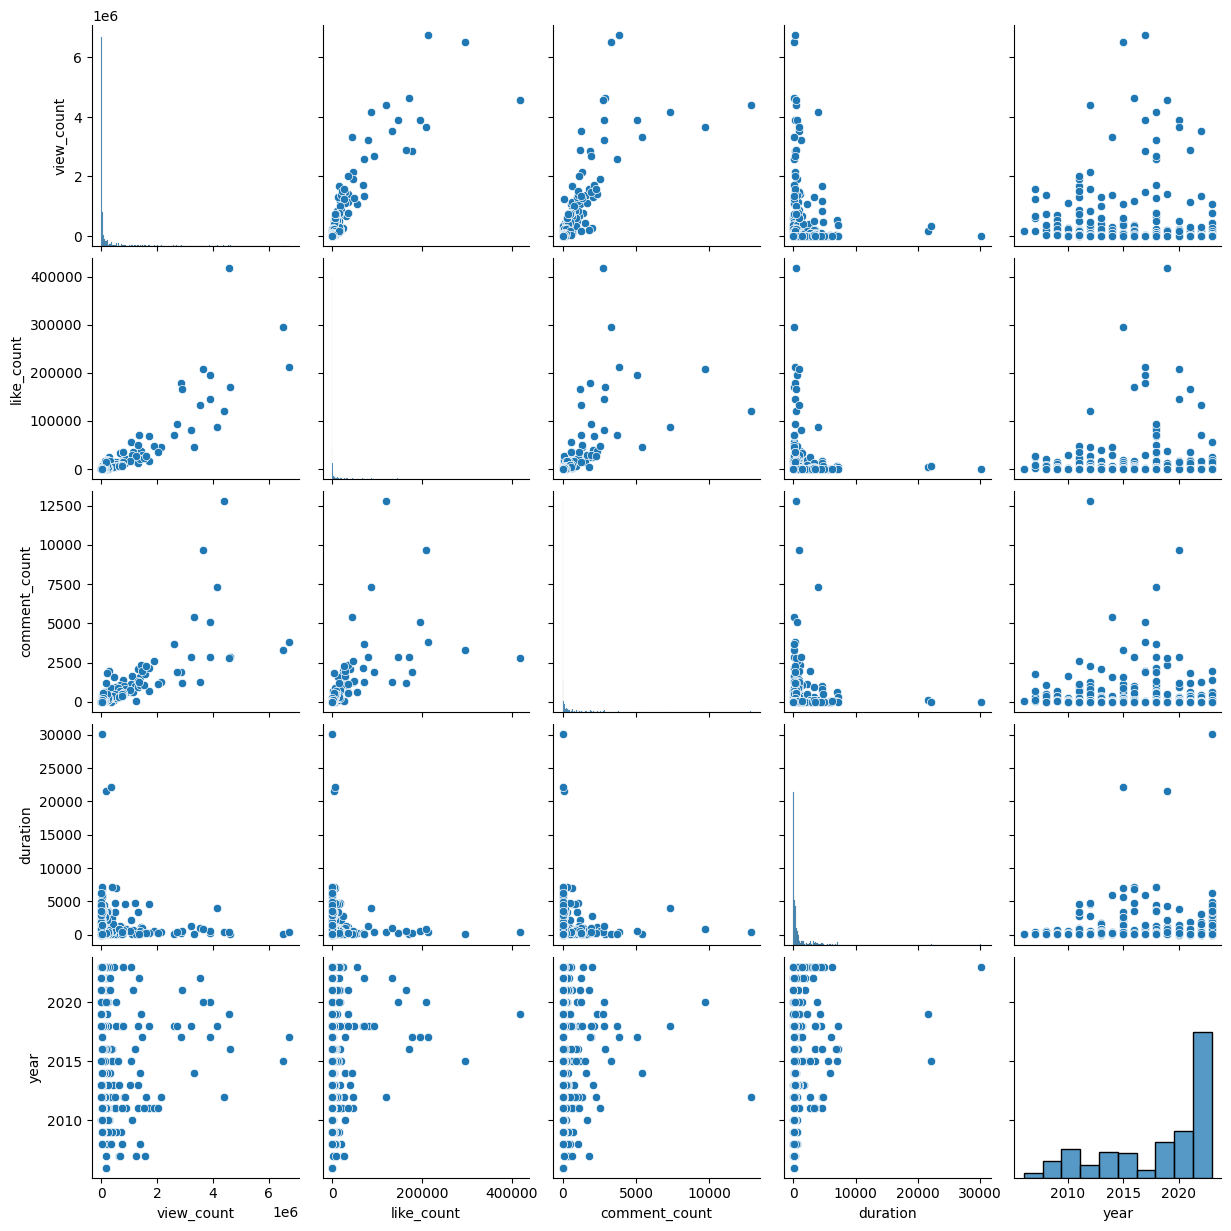

In [118]:
# pairplot of all
sns.pairplot(df)

We can see that different types of views are highly correlated, which makes intuitive sense

In [128]:
df['year'] = df['year'].astype(str)

Text(0.5, 1.0, 'Viewcounts through the years')

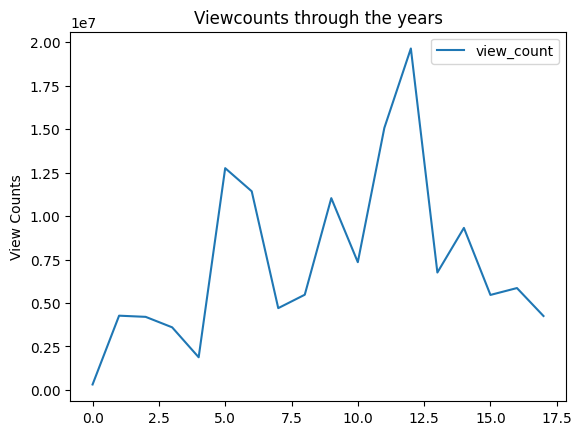

In [134]:
# just trying things out
views_by_year = df.groupby('year')['view_count'].sum().reset_index()
views_by_year.plot()
plt.ylabel('View Counts')
plt.title('Viewcounts through the years')

<Axes: xlabel='year', ylabel='view_count'>

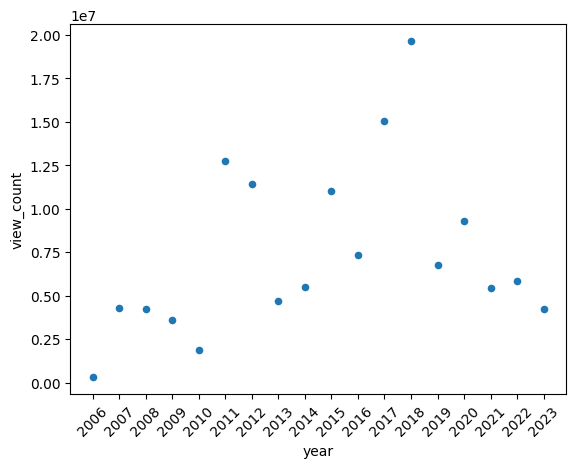

In [138]:
views_by_year.plot.scatter(x='year',y='view_count',rot=45)

Apparently older videos do not automatically higher accumulating view counts. Our goal is to figure out what factors influence this metric the most. 
We can account for the issue of time trends in a time series later.

Now let's see the 10 most viewed, most liked, and most commented videos of RPF.

In [141]:
# most viewed
df.sort_values(by='view_count',ascending=False).head(10)

,title,view_count,like_count,comment_count,publish_time,duration,language,description,tags,channel,date,time,year,tag_num
48,How to Learn Faster with the Feynman Technique...,6745863,212705,3807,2017-02-08T02:18:03Z,348.0,en,"If you want to cut your study time, using the ...","[thomas frank, college info geek, college tips...",Thomas Frank,2017-02-08,02:18:03,2017,17
29,The Feynman Technique,6505048,295956,3274,2015-10-12T11:40:51Z,122.0,en,Richard Feynman was a physicist who received a...,"[Feynmann, Richard Feynmann, learning techniqu...",Sprouts,2015-10-12,11:40:51,2015,18
4,The best teacher I never had,4618209,170957,2872,2016-01-27T16:01:46Z,156.0,en,A video tribute from Bill Gates to Richard Fey...,[],Bill Gates,2016-01-27,16:01:46,2016,2
66,Como Aprender TUDO Que Quiser: Técnica Feynman...,4569040,417840,2785,2019-05-30T00:46:54Z,453.0,pt,💡 𝗖𝗨𝗥𝗦𝗢 𝗘𝘂𝗿𝗲𝗸𝗮!\nComo Vender Ideias com Vídeos...,"[richard feynman, aprendizado, reter, memória,...",Eureka!,2019-05-30,00:46:54,2019,15
7,Richard Feynman. Why.,4385090,120677,12801,2012-04-02T12:18:49Z,453.0,None,Richard Feynman. Why.,"[Richard, Feynman, Why]",firewalker,2012-04-02,12:18:49,2012,3
0,The complete FUN TO IMAGINE with Richard Feynman,4165520,87497,7292,2018-11-01T13:22:07Z,4010.0,en-US,You can find an HD upload at https://youtu.be/...,"[feynman, science, physics, history, philosoph...",Christopher Sykes,2018-11-01,13:22:07,2018,36
239,Daha etkili öğrenmek için ne yapmak gerek? ...,3896784,195320,5083,2017-11-26T06:00:00Z,561.0,tr,"Öğrenmek, hayatta kazanabileceğimiz belki de e...","[4K, Richard Feynman, Feynman Tekniği, Candace...",Barış Özcan,2017-11-26,06:00:00,2017,29
1,"There's no such thing as MIRACLE, Richard Feyn...",3894360,145637,2841,2020-08-26T20:21:49Z,320.0,None,"In this video, Richard Feynman talks about why...","[study with me, study, music for studying, foc...",BTY 365,2020-08-26,20:21:49,2020,18
497,AYAHUASCA | Cortes do Flow,3644406,208763,9678,2020-07-11T20:00:05Z,922.0,None,RICHARD RASMUSSEN - Flow Podcast #160\nhttps:/...,"[flowpodcast777, FLOW, FLOW PODCAST, PODCAST, ...",Cortes do Flow Oficial,2020-07-11,20:00:05,2020,18
80,My Biggest Studying Mistake - The Feynman Tech...,3532525,133042,1276,2022-06-24T16:00:10Z,979.0,en,Get Nebula using my link for 40% off an annual...,"[zach highley, study tips, best study tips, st...",Zach Highley,2022-06-24,16:00:10,2022,26


The top 10 videos are mostly about studying techniques as well as motivations. There are, interestingly, 2 non-English videos and 1 from Bill Gates talking about RPF as a teacher. 

The non-meta video in which RPF is featured talking and answering interview questions throughout is number 6, 7, 9 on the list. All of these are snippets and full cuts from a BBC-affiliated interview right before his death where he sat down and just discussed various physical phenomena in layman terms.

In [143]:
# most liked
df.sort_values(by='like_count',ascending=False).head(10)

,title,view_count,like_count,comment_count,publish_time,duration,language,description,tags,channel,date,time,year,tag_num
66,Como Aprender TUDO Que Quiser: Técnica Feynman...,4569040,417840,2785,2019-05-30T00:46:54Z,453.0,pt,💡 𝗖𝗨𝗥𝗦𝗢 𝗘𝘂𝗿𝗲𝗸𝗮!\nComo Vender Ideias com Vídeos...,"[richard feynman, aprendizado, reter, memória,...",Eureka!,2019-05-30,00:46:54,2019,15
29,The Feynman Technique,6505048,295956,3274,2015-10-12T11:40:51Z,122.0,en,Richard Feynman was a physicist who received a...,"[Feynmann, Richard Feynmann, learning techniqu...",Sprouts,2015-10-12,11:40:51,2015,18
48,How to Learn Faster with the Feynman Technique...,6745863,212705,3807,2017-02-08T02:18:03Z,348.0,en,"If you want to cut your study time, using the ...","[thomas frank, college info geek, college tips...",Thomas Frank,2017-02-08,02:18:03,2017,17
497,AYAHUASCA | Cortes do Flow,3644406,208763,9678,2020-07-11T20:00:05Z,922.0,None,RICHARD RASMUSSEN - Flow Podcast #160\nhttps:/...,"[flowpodcast777, FLOW, FLOW PODCAST, PODCAST, ...",Cortes do Flow Oficial,2020-07-11,20:00:05,2020,18
239,Daha etkili öğrenmek için ne yapmak gerek? ...,3896784,195320,5083,2017-11-26T06:00:00Z,561.0,tr,"Öğrenmek, hayatta kazanabileceğimiz belki de e...","[4K, Richard Feynman, Feynman Tekniği, Candace...",Barış Özcan,2017-11-26,06:00:00,2017,29
70,Técnica Feynman - Como aprender qualquer coisa...,2861149,178333,1890,2017-09-02T14:56:11Z,265.0,pt,Você sabia que existem algumas técnicas para a...,"[Richard Feynman, Feynman, Técnica Feynman, Ap...",Life Pins,2017-09-02,14:56:11,2017,24
4,The best teacher I never had,4618209,170957,2872,2016-01-27T16:01:46Z,156.0,en,A video tribute from Bill Gates to Richard Fey...,[],Bill Gates,2016-01-27,16:01:46,2016,2
135,Cómo Aprender TODO Lo Que QUIERAS: TÉCNICA FEY...,2883725,165389,1188,2021-05-03T15:49:18Z,487.0,es-419,Albert Einstein dijo una vez lo siguiente.\n\n...,"[richard feynman, como aprender cualquier cosa...",Super Interesante,2021-05-03,15:49:18,2021,13
1,"There's no such thing as MIRACLE, Richard Feyn...",3894360,145637,2841,2020-08-26T20:21:49Z,320.0,None,"In this video, Richard Feynman talks about why...","[study with me, study, music for studying, foc...",BTY 365,2020-08-26,20:21:49,2020,18
80,My Biggest Studying Mistake - The Feynman Tech...,3532525,133042,1276,2022-06-24T16:00:10Z,979.0,en,Get Nebula using my link for 40% off an annual...,"[zach highley, study tips, best study tips, st...",Zach Highley,2022-06-24,16:00:10,2022,26


Interestingly, there are quite many non-English videos with high number of like counts. This seems to say more about the population of interest than the video content per say. Most of them are recent, dating earliest to 2015.

In [144]:
# most commented
df.sort_values(by='comment_count',ascending=False).head(10)

,title,view_count,like_count,comment_count,publish_time,duration,language,description,tags,channel,date,time,year,tag_num
7,Richard Feynman. Why.,4385090,120677,12801,2012-04-02T12:18:49Z,453.0,None,Richard Feynman. Why.,"[Richard, Feynman, Why]",firewalker,2012-04-02,12:18:49,2012,3
497,AYAHUASCA | Cortes do Flow,3644406,208763,9678,2020-07-11T20:00:05Z,922.0,None,RICHARD RASMUSSEN - Flow Podcast #160\nhttps:/...,"[flowpodcast777, FLOW, FLOW PODCAST, PODCAST, ...",Cortes do Flow Oficial,2020-07-11,20:00:05,2020,18
0,The complete FUN TO IMAGINE with Richard Feynman,4165520,87497,7292,2018-11-01T13:22:07Z,4010.0,en-US,You can find an HD upload at https://youtu.be/...,"[feynman, science, physics, history, philosoph...",Christopher Sykes,2018-11-01,13:22:07,2018,36
130,The Common Character Trait of Geniuses | James...,3330239,45392,5424,2014-01-10T17:28:01Z,156.0,en,What are the common character traits of genius...,"[Big Think, BigThink, BigThink.com, Education,...",Big Think,2014-01-10,17:28:01,2014,26
239,Daha etkili öğrenmek için ne yapmak gerek? ...,3896784,195320,5083,2017-11-26T06:00:00Z,561.0,tr,"Öğrenmek, hayatta kazanabileceğimiz belki de e...","[4K, Richard Feynman, Feynman Tekniği, Candace...",Barış Özcan,2017-11-26,06:00:00,2017,29
48,How to Learn Faster with the Feynman Technique...,6745863,212705,3807,2017-02-08T02:18:03Z,348.0,en,"If you want to cut your study time, using the ...","[thomas frank, college info geek, college tips...",Thomas Frank,2017-02-08,02:18:03,2017,17
148,Cosine: The exact moment Jeff Bezos decided no...,2591104,71254,3685,2018-09-17T00:19:31Z,141.0,None,,[],Tidefall Capital,2018-09-17,00:19:31,2018,2
29,The Feynman Technique,6505048,295956,3274,2015-10-12T11:40:51Z,122.0,en,Richard Feynman was a physicist who received a...,"[Feynmann, Richard Feynmann, learning techniqu...",Sprouts,2015-10-12,11:40:51,2015,18
4,The best teacher I never had,4618209,170957,2872,2016-01-27T16:01:46Z,156.0,en,A video tribute from Bill Gates to Richard Fey...,[],Bill Gates,2016-01-27,16:01:46,2016,2
67,Feynman's Lost Lecture (ft. 3Blue1Brown),3216879,80162,2848,2018-07-20T13:33:11Z,1304.0,en,Check out Grant’s channel: 3blue1brown: https:...,"[physics, minutephysics, science, 3blue1brown]",minutephysics,2018-07-20,13:33:11,2018,4


This comment_count feature is quite intriguing. There are completely new videos from the previous 2 rankings include 3B1B-featured Feynman's Lost Lecture, one about Jeff Bezos talking about leaving physics and one on James Gleick's general discussion of geniuses. Having watched 2 out of 3, I think I can make a conjecture of the reasons behind their popularities.

#### Duration

Text(0, 0.5, '# of videos')

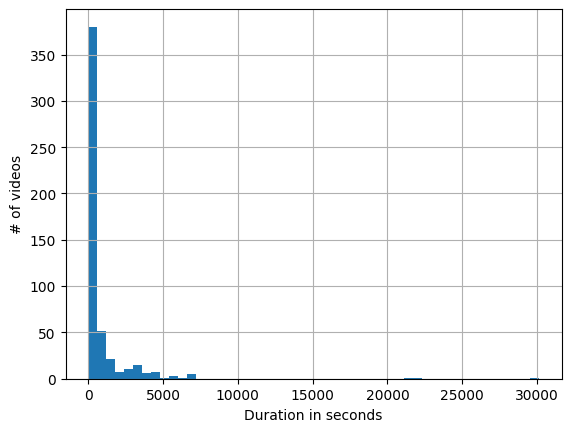

In [150]:
df['duration'].hist(bins=50)
plt.xlabel('Duration in seconds')
plt.ylabel('# of videos')


In [153]:
# relationship between duration and view_count
df[['duration','view_count']].corr() # practically no relation

,duration,view_count
duration,1.000000,0.013729
view_count,0.013729,1.000000


In [152]:
# ranking of duration
df.sort_values(by='duration',ascending=False).head(10)

,title,view_count,like_count,comment_count,publish_time,duration,language,description,tags,channel,date,time,year,tag_num
21,Full Audiobook - The Pleasure of Finding Thing...,12108,294,7,2023-03-31T02:22:56Z,30132.0,None,The Pleasure of Finding Things Out is a magnif...,"[audiobook, biography, science]",Audiobook Codex,2023-03-31,02:22:56,2023,3
22,Today's Answers to Newton's Queries about Ligh...,334278,6362,0,2015-06-03T07:11:36Z,22132.0,None,0:00:00 Photons: Corpuscles of Light\n1:17:32 ...,"[physics, richard feynman, feynman, Isaac Newt...",Trev M,2015-06-03,07:11:36,2015,6
18,Richard Feynman - The Character of Physical La...,153658,3306,107,2019-02-01T21:13:03Z,21589.0,None,"Feynman's Messenger Lectures on the ""Character...","[richard feynman, physics, quantum, qed, gener...",Richard Feynman's Lectures,2019-02-01,21:13:03,2019,7
198,"Pavel Cejnar: Richard Feynman - vědec, učitel,...",15475,168,9,2018-10-15T19:32:57Z,7156.0,cs,Záznam první přednášky z podzimního cyklu před...,[],LLionTV,2018-10-15,19:32:57,2018,2
224,"Pavel Cejnar: Richard Feynman - vědec, učitel,...",15475,168,9,2018-10-15T19:32:57Z,7156.0,cs,Záznam první přednášky z podzimního cyklu před...,[],LLionTV,2018-10-15,19:32:57,2018,2
40,Richard Feynman: Quantum Mechanical View of Re...,371326,4368,323,2016-01-31T17:43:16Z,7114.0,en-GB,"In this series of 4 lectures, Richard Feynman ...","[Feynman, Richard Feynman, quantum, quantum me...",mrtp,2016-01-31,17:43:16,2016,23
32,Richard Feynman: Quantum Mechanical View of Re...,523828,5616,641,2015-12-22T22:52:56Z,7047.0,en-GB,"In this series of 4 lectures, Richard Feynman ...","[Einstein, Albert Einstein, RIchard Feynman, F...",mrtp,2015-12-22,22:52:56,2015,20
192,Richard Feynman: Quantum Mechanical View of R...,28872,348,36,2016-12-24T20:10:25Z,6873.0,en-GB,"In this series of 4 lectures, Richard Feynman ...","[Albert Einstein, Richard Feynman, Feynman dia...",mrtp,2016-12-24,20:10:25,2016,13
477,💓The Clueless Mr. Feynman💓,184,18,23,2023-11-20T09:56:36Z,6225.0,en,I'm a bit congested and slowly recovering from...,"[Bill Gaede, Rational Science, Rope Hypothesis...",Rational Science,2023-11-20,09:56:36,2023,8
288,Richard Feynman on Quantum Mechanics Part 3 El...,5424,0,0,2017-11-14T05:56:19Z,5996.0,en,Third of the Sir Douglas Robb Lectures done by...,"[Richard Feynman, Aucland]",adrianositizano,2017-11-14,05:56:19,2017,2


In [176]:
df.sort_values(by='duration',ascending=True).head(10)

,title,view_count,like_count,comment_count,publish_time,duration,language,description,tags,channel,date,time,year,tag_num,title_len,desc_len
387,Richard Feynman Advice On How To...... - #mubi...,1818,0,0,2023-02-27T07:53:58Z,6.0,None,"What Is Life Motivational short.\n\nRemember, ...","[motivational, motivational quotes, motivation...",Mubi,2023-02-27,07:53:58,2023,16,12,78
438,𝗚𝗥𝗘𝗔𝗧 𝗧𝗛𝗜𝗡𝗞𝗘𝗥𝗦 𝗦𝗣𝗘𝗔𝗞: 𝗥𝗜𝗖𝗛𝗔𝗥𝗗 𝗙𝗘𝗬𝗡𝗠𝗔𝗡,5,0,0,2023-11-16T22:00:49Z,7.0,None,Richard Phillips Feynman was an American theor...,[],Tony Gavin,2023-11-16,22:00:49,2023,2,5,69
464,Jeśli nie potrafisz czegoś wyjaśnić prostym ję...,1,0,0,2023-11-18T16:00:18Z,8.0,pl,Jeśli nie potrafisz czegoś wyjaśnić prostym ję...,"[cytaty znanych ludzi, słowa filozofa, między ...",Słuchaj i Myśl,2023-11-18,16:00:18,2023,28,11,27
322,Quote from Richard Feynman | The Philosophers ...,2693,69,0,2023-06-16T02:00:00Z,8.0,None,Famous Quote from the Physicist Richard Feynma...,"[philosophers, seneca, greek philosopher, Stoi...",The Philosophers Cult,2023-06-16,02:00:00,2023,31,11,18
425,Richard Feynman - Knowledge,55,0,0,2021-06-03T18:49:24Z,9.0,None,#shorts #quotes #gnsdtc\nI don't know what's t...,[],Gnsd.tc,2021-06-03,18:49:24,2021,2,4,36
419,Richard Feynman - The Name,66,2,0,2021-06-05T23:06:22Z,9.0,None,#shorts #quotes #gnsdtc\nI learned very early ...,[],Gnsd.tc,2021-06-05,23:06:22,2021,2,5,23
487,Robert Downey jr best performance ever 💯 #oppe...,2003,38,0,2023-11-19T17:47:49Z,9.0,en-US,Oppenheimer\n2023 ‧ Thriller/Thriller\n\nDurin...,"[oppenheimer, barbie, barbenheimer, Christophe...",Point To Point,2023-11-19,17:47:49,2023,23,11,291
446,Richard Feynman - Knowing,46,1,0,2021-06-05T22:47:09Z,9.0,None,#shorts #quotes #gnsdtc\n\nI don't know anythi...,[],Gnsd.tc,2021-06-05,22:47:09,2021,2,4,27
179,Richard Feynman Life Lesson on Study,32932,1206,22,2022-02-08T16:46:59Z,10.0,None,Richard Feynman Life Lesson on Study\n\n#Quant...,"[richard feynman, feynman, richard feynman (ac...",humais,2022-02-08,16:46:59,2022,21,6,385
301,FRASES RICHARD FEYNMAN #short,63,4,0,2022-06-01T04:13:05Z,10.0,None,#RICHARDFEYNMAN\n#FRASESRICHARDFEYNMAN\n#short,[],FELDAN AUDIOLIBROS,2022-06-01,04:13:05,2022,2,4,3


#### Observation: There are the normal YT videos and YT shorts (limited to under 60 seconds max). Assuming that all videos shorter than 60s are really shorts, let's explore this further.

##### Create a new col to classify videos into normal or shorts (1 = short, 0 otherwise)

In [178]:
df[df['duration'] < 60].shape # 132 shorts in total

(132, 16)

In [181]:
df['short_vid'] = df['duration'].apply(lambda x: 1 if x <= 60 else 0)

Now let's sort again, this time with short classifier present

In [184]:
df[['title','view_count','like_count','comment_count','duration','short_vid']]

,title,view_count,like_count,comment_count,duration,short_vid
0,The complete FUN TO IMAGINE with Richard Feynman,4165520,87497,7292,4010.0,0
1,"There's no such thing as MIRACLE, Richard Feyn...",3894360,145637,2841,320.0,0
2,Richard Feynman talks about Algebra,1383026,28242,1592,82.0,0
3,Inside the Mind of Richard Feynman: The Great ...,1295632,40328,2102,624.0,0
4,The best teacher I never had,4618209,170957,2872,156.0,0
...,...,...,...,...,...,...
506,"Estrellas, galaxias, cúmulos y supercúmulos",48,1,1,4518.0,0
507,Curiosity(Carly Rae Jepsen) Audioswap,93,5,0,94.0,0
508,Complete Masterclass on Communication: From No...,28037,1863,97,3333.0,0
509,Simplicity and symmetry in physics,103,8,0,3553.0,0


In [187]:
# average counts of shorts vs normal videos
df.groupby('short_vid')[['view_count','like_count','comment_count']].mean()

,view_count,like_count,comment_count
short_vid,,,
0,356096.767760,11418.937158,384.180328
1,20738.096552,752.186207,22.772414


array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

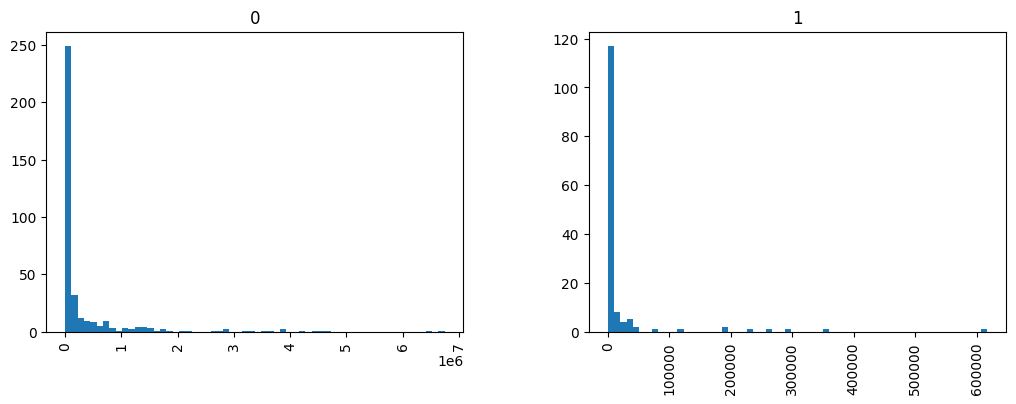

In [185]:
df.hist(column='view_count',by='short_vid',bins=60,figsize=(12,4),grid=True)

#### Let's examine tag number


<Axes: >

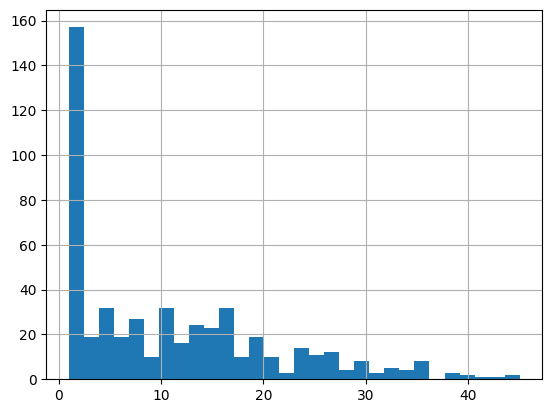

In [159]:
df['tag_num'].value_counts().sort_values(ascending=False) # most common tag_num is 2
df['tag_num'].hist(bins=30)

In [163]:
df.groupby('tag_num').mean().sort_values(by='view_count',ascending=False).head()

C:\Users\MrLinh\AppData\Local\Temp\ipykernel_16012\2539606917.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('tag_num').mean().sort_values(by='view_count',ascending=False).head()


,view_count,like_count,comment_count,duration
tag_num,,,,
36,1.838782e+06,52597.666667,2840.666667,1390.333333
18,1.579902e+06,68528.800000,1792.200000,390.700000
26,8.706541e+05,21838.444444,789.333333,424.444444
29,8.383812e+05,37601.333333,1147.666667,833.500000
25,5.291912e+05,16140.363636,530.181818,373.363636


In [164]:
df.groupby('tag_num').mean().sort_values(by='duration',ascending=False).head()

C:\Users\MrLinh\AppData\Local\Temp\ipykernel_16012\1734048069.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('tag_num').mean().sort_values(by='duration',ascending=False).head()


,view_count,like_count,comment_count,duration
tag_num,,,,
7,106817.000000,2027.300000,103.400000,2443.400000
33,36195.333333,450.333333,18.666667,2381.666667
3,350522.842105,8910.210526,787.684211,2089.526316
6,329078.526316,6039.526316,294.368421,2030.210526
4,318850.437500,8731.437500,373.187500,1507.000000


#### Onto languages (but probably dropping this one)

<Axes: >

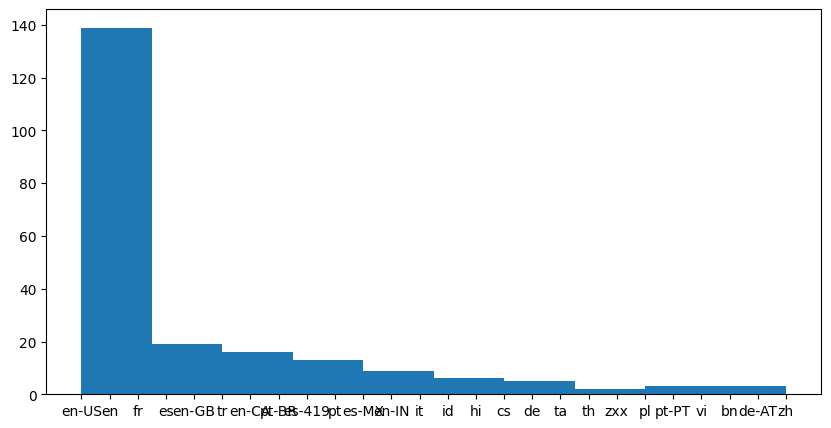

In [60]:
df['language'].hist(figsize=(10,5),grid=False)

In [188]:
# export final dataset
df.to_csv('final_data.csv')